Versions:
* v1: one full cycle. Not yet multiple cycles implemented
* v2: MORDM cycle into IO-function
    * Can be used for MORDM validation
* v3: restructure into MORDM function
* v4: mpmordm iterative way - Finished
* v5: 
    * start Micromodel between iterations
    * start making distance table based on OSRM
    * Both are finished, but not cleaned and integrated in code
    * OSRM is not yet integrated in full process. just done once

TODO inputdata: 
* FL not random generation
* distances based on OSRM route matrix

TODO model:
* Check values for disruption 1-2 of 0-1

TODO:
* #Filter out those where no new demand is covered<br>
    #TODO: Works only first time. After that doesn't work.<br>
    #TODO: Change to "not more than previous round"
* XX done via saving: return information about objective prioritisation for each returned nondom policy and nondom robust policy
* better names inputvariables
* Priority: add extra location to non-dominated with highest information yield
* Priority: change info based on locations

# Imports

In [256]:
# Standard imports & printing versions
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v5 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

import sys

# for routing table:
import osrm

In [244]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [245]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
osrm,0.11.1,,
pandas,0.22.0,,
re,2.2.1,,
sys,"3.6.4 |Anaconda, Inc.| (default, Mar 12 2018, 20:20:50) [MSC v.1900 64 bit (AMD64)]",,


# Data Prep

## Load Data

Data is preliminary data. TODO: Find reliable input data

In [5]:
# Create DPs from Nepal Data
DPs = pd.read_csv("Data/Nepal Cities Population.csv", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
DPs = DPs [DPs.Population >= 50000]
DPs.head(2)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31
1,Biratnagar,178000,26.46,87.28


In [6]:
# Create SPs from Nepal Data
airports = pd.read_csv("Data/Nepal Airports.csv", usecols=[0,5,6])
SPs = airports[airports['Airport'] == "Tribhuvan intl"]
SPs.head(2)

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


In [7]:
# Create random FLs in Nepal
long = np.random.uniform(DPs['Longitude (DD)'].min(),
                         DPs['Longitude (DD)'].max(), 20)
lat = np.random.uniform(DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max(),
                        20)
FLs = pd.DataFrame([lat, long], index=['Lat', 'Lon']).T
FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]
FLs = FLs[['Name', 'Lat', 'Lon']]
FLs.head(2)

,Name,Lat,Lon
0,FLO0,27.582503,83.118232
1,FLO1,27.134981,85.491985


## Prepare Data for model input

### Global: Fixed certain data

In [8]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['Longitude (DD)'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['Population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}


### create distance matrix

In [223]:
node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
    "FL{}".format(i) for i, ind in enumerate(FLs.index)
] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

In [236]:
node_lats = SPs['Latitude (DD)'].append(FLs['Lat']).append(DPs['Latitude (DD)']).reset_index(drop=True)

In [239]:
node_lons = SPs['Longitude (DD)'].append(FLs['Lon']).append(DPs['Longitude (DD)']).reset_index(drop=True)

#### OSRM routing table

TODO: Check time_matrix on diagonal. differences between x->y and y->x

In [257]:
osrm.RequestConfig.host = osrm.RequestConfig.host = "router.project-osrm.org"

In [258]:
# for some reason the coordinates are incorrectly passed by this OSRM package
list_coords = [osrm.Point(longitude=lat, latitude=lon) for lat, lon in zip (node_lats, node_lons)]

In [259]:
time_matrix, snapped_coords, a = osrm.table(
    list_coords, ids_origin=node_names, output='dataframe')

In [261]:
time_matrix.to_csv("Data/routes_play_data.csv")

### Global: Fixed uncertain data

In [9]:
global_fixed_unc = pd.read_csv("Data/uncertainties/fixed_uncertainties.csv").set_index('var')

### Variable Uncertain Data: generate random for now:
DFs becomes a global. can be accessed by using its label

In [10]:
# DSR = Disruption
DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}


In [11]:
# label each branch. start with:
start_label = "p0n0"
# Each branch has a separate perception of what the data is.
# A dictionary can keep track of data for each branch, linked via label
global_dfs_var_unc_data = {}

In [12]:
global_dfs_var_unc_data [start_label] = pd.DataFrame.from_dict({**DSRDP, **DSRFL}, orient='index')

In [13]:
global_dfs_var_unc_data [start_label].head(1)

,0
DSRDP0,1.095545


In [14]:
# create upper and lower bound
global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
    start_label].rename(columns={0: "actual"})
global_dfs_var_unc_data[start_label]['lower'] = (
    global_dfs_var_unc_data[start_label]['actual'] - 1
) * np.random.uniform(size=global_dfs_var_unc_data[start_label].shape[0]) + 1
global_dfs_var_unc_data[start_label]['upper'] = (
    2 - global_dfs_var_unc_data[start_label]['actual']) * np.random.uniform(
        size=global_dfs_var_unc_data[start_label]
        .shape[0]) + global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label]['best_estimate'] = (
    global_dfs_var_unc_data[start_label]['upper'] +
    global_dfs_var_unc_data[start_label]['lower']) / 2
global_dfs_var_unc_data[start_label][
    'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label].head(1)

,actual,lower,upper,best_estimate,difference
DSRDP0,1.095545,1.065224,1.263898,1.164561,0.069016


In [15]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

### Other Globals:
- Create Starting situation policies:
- List of all Models

# MORDM

## Helper functions

In [16]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """
    def natural_key(string_):
        return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
    
    # All FL names
    FL_keys = sorted(FL_dict.keys(),key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [17]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

In [18]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

## Main

In [19]:
def MORDM(
        current=None,
        current_period=None,
        trace_label=None,
        # fixed_data=None,
        # var_data=None,
        n_scenarios=100,
        additional_info=None,
        show_MORDM_graphics=False,
        show_model_graphics=False):
    """
    current: indexes of current operational locations
    trace_label: label of input node
    fixed_data: 
    var_data: df of variable data for each 
    max_depth: maximum number of total FLS
    """
    #     if sum(current.values()) >= max_depth:
    #         raise NotImplementedError(
    #             "Everything might go right(no error). This function is not well implemented. Change to > instead of >="
    #         )

    if show_MORDM_graphics == True:
        raise NotImplementedError("""visualisations are not implemented yet. 
            Not sure yet if impementing graphics in MPMORDM is usefull for every period """
                                  )

    #Start Many Objective Optimisation
    #best estimate values
    best_estimate_disruptions = {
        i: be
        for be, i in zip(global_dfs_var_unc_data[trace_label]['best_estimate'],
                         global_dfs_var_unc_data[trace_label].index)
    }

    optional_policies = create_policies(current, print_pols=False)

    #evaluate all policies
    best_est_results_opt_pols = []
    for policy in optional_policies:
        best_est_results_opt_pols.append(
            FL_model(
                unit_opening_costs=global_fixed_unc.loc["unit_opening_costs",
                                                        "best_estimate"],
                unit_transport_cost=global_fixed_unc.loc["unit_transport_cost",
                                                         "best_estimate"],
                FL_operations_cost=global_fixed_unc.loc["FL_operations_cost",
                                                        "best_estimate"],
                graphical_representation=show_model_graphics,
                FL_range=global_fixed_unc.loc["FL_range",
                                              "best_estimate"],  # km? --> m
                dist_method="great_circle",
                lorry_speed=global_fixed_unc.loc[
                    "lorry_speed", "best_estimate"],  #km/u? --> m/s
                # fixed certain
                **SPX,
                **SPY,
                **DPX,
                **DPY,
                **FLX,
                **FLY,
                **DPpop,
                # specific
                **policy,
                **best_estimate_disruptions))

    # outcome indicators, as internally used by the model
    oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_distr_time'
    ]
    # Put outcomes in DF
    df_best_est_results_opt_pols = pd.DataFrame(
        np.asarray(best_est_results_opt_pols)[:, :4], columns=oois)

    #nondominated sorting
    nondominated_BE_policy_results = np.array(
        pareto.eps_sort(
            [list(df_best_est_results_opt_pols.itertuples(index=True))],
            [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))

    #Filter out those where new demand is covered
    #TODO: Works only first time. After that doesn't work.
    #TODO: Change to "not more than previous round"
    nondominated_BE_policy_results = nondominated_BE_policy_results[
        nondominated_BE_policy_results[:, 4] != 0]

    #put nondominated policies in array
    nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]
    nondominated_BE_policies = np.array(optional_policies)[nondom_i]

    df_nondom_BE_pols = pd.DataFrame(
        nondominated_BE_policy_results, columns=["i"] + oois).set_index("i")
    df_nondom_BE_pols.to_csv(
        "results/mpmordm/nondom_BE_pols{}.csv".format(trace_label))


    #End Many Objective Optimisation
    #Start Robustness analysis

    EMA_model_dict[trace_label] = Model("flmodel{}".format(trace_label),
                                        FL_model)

    EMA_model_dict[trace_label].locations = [
        Constant("DPX{}".format(i), x)
        for i, x in zip(DPs.index, DPs['Longitude (DD)'])
    ] + [
        Constant("DPY{}".format(i), y)
        for i, y in zip(DPs.index, DPs['Latitude (DD)'])
    ] + [
        Constant("SPX{}".format(i), x)
        for i, x in zip(SPs.index, SPs['Longitude (DD)'])
    ] + [
        Constant("SPY{}".format(i), y)
        for i, y in zip(SPs.index, SPs['Latitude (DD)'])
    ] + [
        Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])
    ] + [
        Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
    ]

    # model.locations_uncertain =   [
    #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
    # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

    EMA_model_dict[trace_label].constants = [
        Constant('graphical_representation', False),
        Constant('dist_method', 'great_circle'),
        Constant('Error_Test', 1),  # this doesn't do anything. 
        #list of other constants
        #     Constant
    ] + EMA_model_dict[trace_label].locations + [  # population DPs
        Constant("DPpop{}".format(i), pop)
        for i, pop in zip(DPs.index, DPs['Population'])
    ]

    # Reachability of Demand Points and Facility Locations can be disrupted
    # Disruption also determines demand (disr-1)*pop
    EMA_model_dict[trace_label].disruptions = [
        RealParameter(i, l, u) for i, l, u in zip(global_dfs_var_unc_data[
            trace_label].index, global_dfs_var_unc_data[trace_label][
                'lower'], global_dfs_var_unc_data[trace_label]['upper'])
    ]

    EMA_model_dict[trace_label].uncertainties = [
        RealParameter(i, l, u)
        for i, l, u in zip(global_fixed_unc.index, global_fixed_unc.lower,
                           global_fixed_unc.upper)
    ] + EMA_model_dict[trace_label].disruptions  #+ model.locations_uncertain

    EMA_model_dict[trace_label].outcomes = [
        ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome(
            "max_distr_time",
            kind=ScalarOutcome.MINIMIZE,
        )
    ]

    if [o.name for o in EMA_model_dict[trace_label].outcomes] != oois:
        print("Watch out! Oois and model outcome names are not similar!")

    nondominated_BE_policies_EMA = []
    for name, pol in zip(nondom_i, nondominated_BE_policies):
        nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

    time1 = time.time()
    all_scen_results_nondom_pols = perform_experiments(
        EMA_model_dict[trace_label], n_scenarios, nondominated_BE_policies_EMA)
    time2 = time.time()
    print("Total time:{}".format(time2 - time1), "\n",
          "time per run = {}".format(
              (time2 - time1) /
              (n_scenarios * len(nondominated_BE_policies_EMA))))

    ema.save_results(all_scen_results_nondom_pols,
                     "results/mpmordm/{}.tar.gz".format(trace_label))
    experiments, outcomes = all_scen_results_nondom_pols

    sigN_results = []

    for policy in nondominated_BE_policies_EMA:
        #filter the outcome values corresponding to each policy using a logical index
        logical_index = experiments['policy'] == policy.name
        # If ever something goes wrong here, probably add: int() to policy.name
        pol_outcomes = {
            key: outcomes[key][logical_index]
            for key in outcomes.keys()
        }
        temp_result = {}
        for ooi in EMA_model_dict[trace_label].outcomes:
            temp_result[ooi.name] = calculate_signalNoise(
                pol_outcomes[ooi.name], ooi.kind)
        sigN_results.append(temp_result)

    df_sigN = pd.DataFrame(
        sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])

    reg_results = {}
    # we need to iterate over the outcomes differently now,
    #because the maximum egret calculation requires the outcome values for all policies
    for ooi in EMA_model_dict[trace_label].outcomes:
        data = []
        for policy in nondominated_BE_policies_EMA:
            logical_index = experiments['policy'] == policy.name
            # If ever something goes wrong here, add int() to policy.name
            data.append(outcomes[ooi.name][logical_index])
        reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    df_regret = pd.DataFrame.from_dict(
        reg_results,
        orient='columns',
    )
    df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]

    all_robustness_scores = pd.merge(
        df_regret,
        df_sigN,
        left_index=True,
        right_index=True,
        suffixes=("_regret", "_sigN"))

    robust_nondominated_policies = pareto.eps_sort(
        [list(all_robustness_scores.itertuples(index=True))],
        [i + 1 for i in range(all_robustness_scores.shape[1])],
        [1e-9] * all_robustness_scores.shape[1])

    if len(robust_nondominated_policies) == 0:
        print("something went wrong")
    elif len(robust_nondominated_policies) == 1:
        print("no branching, only a single nondominated robust location")
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)

        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
    #     print(robust_nondominated_policies)
    else:
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)
        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    df_rob_nondom_pols.to_csv(
        "results/mpmordm/nondom_rob_pols{}.csv".format(trace_label))

    rob_nondom_i = [int(i) for i in df_rob_nondom_pols.index]
    #     return df_rob_nondom_pols
    
    return np.array(optional_policies)[rob_nondom_i]

## Testing single cycle

TODO: save csv nondom pols + csv rob nondom pols
possible: clear op variable space with del

In [20]:
# test = MORDM(
#     current=start_situation,n_scenarios=10, trace_label=start_label)

# Full cycle

In [21]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

Now first: label management

In [22]:
def change_decision_based_uncertainty(current_uncertain_data):
    return current_uncertain_data

In [23]:
periods = 2 # 1 location per period -> locations = periods

global_node_counter = 0

start_situation = {key:0 for key in FLs.Name}
global_policy_tree = {start_label : start_situation}
global_label_tree = {
    "p{}".format(p, global_node_counter): []
    if p != 0 else ["{}".format(start_label)]
    for p in range(periods+1)
}

EMA_model_dict = {}  # XX somewhere else: global
print("starting label:", start_label)


for p in range(periods):
    for node_i, node in enumerate(list(global_label_tree["p{}".format(p)])):
#         print("|", p, node)
        if p < periods:
            print("Do mordm, in period:", p,"label:", node,"policy:",global_policy_tree[node])
#             new_pols = ["a", "b", "c"]
            new_pols = MORDM(current=global_policy_tree[node],n_scenarios=10, trace_label=node)
            for new_pol in new_pols:
                # Create new label
                global_node_counter += 1
                new_label = node + "p{}n{}".format(p + 1, global_node_counter)
                print("result:|||",new_label)
                # Create new branch
                global_label_tree["p{}".format(p + 1)].append(new_label)
                # add new policy
                global_policy_tree[new_label] = new_pol
                # change information based on policy
                #TODO not implemented yet
#                 global_dfs_var_unc_data[new_label] = global_dfs_var_unc_data[start_label]
                global_dfs_var_unc_data[new_label] = change_decision_based_uncertainty(global_dfs_var_unc_data[node])

                
                
                
        else:
            print(p,
                "if you see this, sth went wrong."
            )
#     print("__end_period:",p)

starting label: p0n0
Do mordm, in period: 0 label: p0n0 policy: {'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0, 'FLO6': 0, 'FLO7': 0, 'FLO8': 0, 'FLO9': 0, 'FLO10': 0, 'FLO11': 0, 'FLO12': 0, 'FLO13': 0, 'FLO14': 0, 'FLO15': 0, 'FLO16': 0, 'FLO17': 0, 'FLO18': 0, 'FLO19': 0}


[MainProcess/INFO] performing 10 scenarios * 4 policies * 1 model(s) = 40 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm\p0n0.tar.gz


Total time:1.9089076519012451 
 time per run = 0.04772269129753113
result:||| p0n0p1n1
result:||| p0n0p1n2
Do mordm, in period: 1 label: p0n0p1n1 policy: {'FLO0': 1.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}


[MainProcess/INFO] performing 10 scenarios * 4 policies * 1 model(s) = 40 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm\p0n0p1n1.tar.gz


Total time:1.8749277591705322 
 time per run = 0.0468731939792633
result:||| p0n0p1n1p2n3
result:||| p0n0p1n1p2n4
result:||| p0n0p1n1p2n5
Do mordm, in period: 1 label: p0n0p1n2 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}


[MainProcess/INFO] performing 10 scenarios * 6 policies * 1 model(s) = 60 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] 42 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] 54 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm\p0n0p1n2.tar.gz


Total time:2.802400827407837 
 time per run = 0.04670668045679728
result:||| p0n0p1n2p2n6
result:||| p0n0p1n2p2n7
result:||| p0n0p1n2p2n8
result:||| p0n0p1n2p2n9
result:||| p0n0p1n2p2n10
result:||| p0n0p1n2p2n11


In [24]:
global_label_tree

{'p0': ['p0n0'],
 'p1': ['p0n0p1n1', 'p0n0p1n2'],
 'p2': ['p0n0p1n1p2n3',
  'p0n0p1n1p2n4',
  'p0n0p1n1p2n5',
  'p0n0p1n2p2n6',
  'p0n0p1n2p2n7',
  'p0n0p1n2p2n8',
  'p0n0p1n2p2n9',
  'p0n0p1n2p2n10',
  'p0n0p1n2p2n11']}

In [25]:
global_label_tree

{'p0': ['p0n0'],
 'p1': ['p0n0p1n1', 'p0n0p1n2'],
 'p2': ['p0n0p1n1p2n3',
  'p0n0p1n1p2n4',
  'p0n0p1n1p2n5',
  'p0n0p1n2p2n6',
  'p0n0p1n2p2n7',
  'p0n0p1n2p2n8',
  'p0n0p1n2p2n9',
  'p0n0p1n2p2n10',
  'p0n0p1n2p2n11']}

In [38]:
EMA_model_dict

{'p0n0': <ema_workbench.em_framework.model.Model at 0x2ae33da7358>,
 'p0n0p1n1': <ema_workbench.em_framework.model.Model at 0x2ae33e664e0>,
 'p0n0p1n2': <ema_workbench.em_framework.model.Model at 0x2ae33e66a58>}

In [39]:
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0 []
p0n0p1n1 ['FLO0']
p0n0p1n2 ['FLO2']
p0n0p1n1p2n3 ['FLO0', 'FLO2']
p0n0p1n1p2n4 ['FLO0', 'FLO14']
p0n0p1n1p2n5 ['FLO0', 'FLO19']
p0n0p1n2p2n6 ['FLO0', 'FLO2']
p0n0p1n2p2n7 ['FLO2', 'FLO4']
p0n0p1n2p2n8 ['FLO2', 'FLO6']
p0n0p1n2p2n9 ['FLO2', 'FLO14']
p0n0p1n2p2n10 ['FLO2', 'FLO15']
p0n0p1n2p2n11 ['FLO2', 'FLO19']


In [29]:
# only those nodes that branch from n2
for key in global_policy_tree.keys():
    if "n2" in key:
        poldict = global_policy_tree[key]
        print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0p1n2 ['FLO2']
p0n0p1n2p2n6 ['FLO0', 'FLO2']
p0n0p1n2p2n7 ['FLO2', 'FLO4']
p0n0p1n2p2n8 ['FLO2', 'FLO6']
p0n0p1n2p2n9 ['FLO2', 'FLO14']
p0n0p1n2p2n10 ['FLO2', 'FLO15']
p0n0p1n2p2n11 ['FLO2', 'FLO19']


## Development of micromodel:

In [107]:
df_test = global_dfs_var_unc_data['p0n0']

In [264]:
time_matrix.head(2)

,SP0,FL0,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,...,DP8,DP9,DP10,DP11,DP12,DP13,DP14,DP15,DP16,DP17
SP0,0.0,22985.0,15488.3,7322.1,45697.2,18472.8,36158.1,45596.2,24661.5,30495.5,...,47678.8,1263.1,19383.2,10013.3,46347.7,35837.0,26720.9,32937.9,20912.0,1088.2
FL0,21864.2,0.0,22430.4,22210.2,58343.7,22473.2,16745.5,52538.3,10961.2,47787.0,...,28266.2,21817.1,3886.8,16955.4,26935.1,16424.4,33663.0,39880.0,5769.6,21642.2


Assumption:
- dps change information the same as fls
- not only based on last added fl, but for all operational fl.
- linear function based on distance. further away, less information
- information changes only based on distance. not on allocation, as it's unsure if location is allocated
    - To improve this, use sigmoid function instead of linear.
    - then steepest part is on the estimated covering distance

In [624]:
def new_est_low_up(row, fl_n):
    """Validated"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]

    unc_red = linear(dist/1000, 50)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    low_new = be_new - 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    up_new = be_new + 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    return low_new, be_new, up_new

In [627]:
def change_decision_based_uncertainty(df, fls):
    df2 = df.copy(deep=True)
    for fl in fls:
        print(fl)
        df2['lower'], df2['best_estimate'], df2['upper'] = zip(
            *df_test.apply(lambda row: new_est_low_up(row, 13), axis=1))
    return df2


df3 = change_decision_based_uncertainty(df_test, [2, 3])

2
3


In [629]:
df_test

,actual,lower,upper,best_estimate,difference,a,b,c
DSRDP0,1.095545,1.065224,1.263898,1.164561,0.069016,1.072166,1.148760,1.225355
DSRDP1,1.575701,1.359655,1.826360,1.593008,0.017307,1.359655,1.593008,1.826360
DSRDP2,1.697693,1.069009,1.895886,1.482447,-0.215246,1.213775,1.532012,1.850248
DSRDP3,1.009035,1.002301,1.228025,1.115163,0.106128,1.004758,1.076447,1.148136
DSRDP4,1.957269,1.582159,1.982386,1.782273,-0.174996,1.672237,1.824296,1.976354
DSRDP5,1.428245,1.419164,1.869841,1.644502,0.216257,1.419164,1.644502,1.869841
DSRDP6,1.840356,1.142181,1.884134,1.513157,-0.327199,1.433593,1.649728,1.865862
DSRDP7,1.036414,1.017780,1.138319,1.078050,0.041636,1.019609,1.073964,1.128318
DSRDP8,1.381361,1.144269,1.914257,1.529263,0.147902,1.310553,1.425533,1.540512
DSRDP9,1.149976,1.118657,1.196814,1.157736,0.007759,1.125411,1.156062,1.186714


In [622]:
df_test['a'], df_test['b'], df_test['c'] = zip(
    *df_test.apply(lambda row: new_est_low_up(row, 13), axis=1))

In [130]:
Xs = [s[3:5]+"X"+s[5:] for s in df_test.index]
Ys = [s[3:5]+"Y"+s[5:] for s in df_test.index]

In [474]:
5/400

0.0125

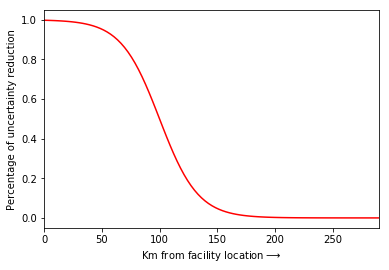

In [491]:
sig_height = 1
sig_length = 100 # TODO should be more or less equal to expected max_cov distance. 
sig_steepness = -0.06 #steepness chosen arbitrarily to create nice curve

sigmoid = lambda x: sig_height / (1 + np.exp(- sig_steepness*(x-sig_length)))
# x=np.linspace(0,10,10)
y=np.linspace(0,sig_length*3,100)
plt.plot(y,sigmoid(y),'r')
plt.xlabel(r'Km from facility location$\longrightarrow$')
plt.ylabel("Percentage of uncertainty reduction")
plt.xlim((0,sig_length*2.9))
plt.show()

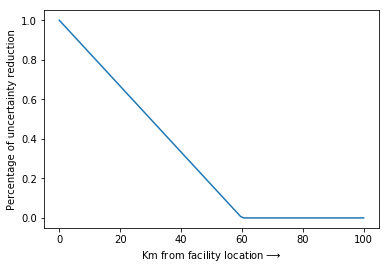

In [602]:
def linear_plot(x, dist):
        return [max(min(1 - (1/dist) * y,1),0) for y in x]


y=np.linspace(0,100,100)
plt.plot(y,linear_plot(y, 60))
plt.xlabel(r'Km from facility location$\longrightarrow$')
plt.ylabel("Percentage of uncertainty reduction")
# plt.xlim((0,sig_length*2.9))
plt.show()

In [613]:

def linear(x, dist):
    return max(min(1 - (1/dist) * x,1),0)

def new_estimate(row, fl_n):
    """Validated"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]

    unc_red = linear(dist/1000, 50)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    return (unc_red,be_new) 

def new_lower_upper(row,fl_n):
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]
    unc_red = linear(dist/1000, 50)
    low_new = row["best_"]

In [610]:
df_test.apply(lambda row: new_estimate(row,13) , axis=1)

DSRDP0     (0.22894000000000003, 1.1487603044323977)
DSRDP1                       (0, 1.5930078198757767)
DSRDP2     (0.23026800000000003, 1.5320115522710251)
DSRDP3                (0.364804, 1.0764468770964324)
DSRDP4      (0.24013600000000013, 1.824295574379842)
DSRDP5                       (0, 1.6445023858384027)
DSRDP6                 (0.417392, 1.649727536542536)
DSRDP7      (0.0981439999999999, 1.0739635129888359)
DSRDP8                 (0.701348, 1.425532563814146)
DSRDP9      (0.21564399999999995, 1.156062383084275)
DSRDP10     (0.5742499999999999, 1.2183673074933419)
DSRDP11               (0.312878, 1.2273171950438784)
DSRDP12                (0.72797, 1.4683987892828356)
DSRDP13               (0.876338, 1.1414210633959203)
DSRDP14                      (0, 1.4138151164955919)
DSRDP15                      (0, 1.4097155276037843)
DSRDP16               (0.532084, 1.1120171156653589)
DSRDP17    (0.21914199999999995, 1.3950061010109946)
DSRFL0                (0.580452, 1.87321663548

In [623]:
df_test.head(3)

,actual,lower,upper,best_estimate,difference,a,b,c
DSRDP0,1.095545,1.065224,1.263898,1.164561,0.069016,1.072166,1.148760,1.225355
DSRDP1,1.575701,1.359655,1.826360,1.593008,0.017307,1.359655,1.593008,1.826360
DSRDP2,1.697693,1.069009,1.895886,1.482447,-0.215246,1.213775,1.532012,1.850248


In [85]:
global_dfs_var_unc_data['p0n0'].head()

,actual,lower,upper,best_estimate,difference
DSRDP0,1.095545,1.065224,1.263898,1.164561,0.069016
DSRDP1,1.575701,1.359655,1.826360,1.593008,0.017307
DSRDP2,1.697693,1.069009,1.895886,1.482447,-0.215246
DSRDP3,1.009035,1.002301,1.228025,1.115163,0.106128
DSRDP4,1.957269,1.582159,1.982386,1.782273,-0.174996


# check for size of dictionary and its items

In [66]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


# ##### Example call #####

# if __name__ == '__main__':
#     d = dict(a=1, b=2, c=3, d=[4,5,6,7], e='a string of chars')
#     print(total_size(d, verbose=True))

In [70]:
print(total_size(global_dfs_var_unc_data, verbose=True))

5890


648 <class 'dict'> {'p0n0':            ac...97   -0.111750, 'p0n0p1n1':            ac...97   -0.111750, 'p0n0p1n1p2n3':            ac...97   -0.111750, 'p0n0p1n1p2n4':            ac...97   -0.111750, ...}
53 <class 'str'> 'p0n0'
4524 <class 'pandas.core.frame.DataFrame'>            ac...97   -0.111750
57 <class 'str'> 'p0n0p1n1'
57 <class 'str'> 'p0n0p1n2'
61 <class 'str'> 'p0n0p1n1p2n3'
61 <class 'str'> 'p0n0p1n1p2n4'
61 <class 'str'> 'p0n0p1n1p2n5'
61 <class 'str'> 'p0n0p1n2p2n6'
61 <class 'str'> 'p0n0p1n2p2n7'
61 <class 'str'> 'p0n0p1n2p2n8'
61 <class 'str'> 'p0n0p1n2p2n9'
62 <class 'str'> 'p0n0p1n2p2n10'
62 <class 'str'> 'p0n0p1n2p2n11'
